In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

from utils import mnist, plot_graphs, plot_graphs_double_logs

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=40000)

In [3]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 16)
        self.fc2 = nn.Linear(16, 128)
        self.fc3 = nn.Linear(128, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(16)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [4]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.2f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * int(correct[k]) / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [5]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)
    
    if log:
        test(models, train_loader, log)

In [6]:
models = {'default': Net(False, False), 'bn': Net(True, False), 'drop': Net(False, True), 'both': Net(True, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
for epoch in range(1, 301):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [0/20000 (0%)]	Losses default: 2.322228 bn: 2.325983 drop: 2.239169 both: 2.336496
Train Epoch: 1 [10000/20000 (50%)]	Losses default: 1.465806 bn: 1.582551 drop: 1.632796 both: 1.679230
Train Epoch: 1 [20000/20000 (100%)]	Losses default: 0.986962 bn: 1.115663 drop: 1.199860 both: 1.250770
Test set:
default: Loss: 0.9718	Accuracy: 16180/20000 (80.90%)
bn: Loss: 1.1230	Accuracy: 16234/20000 (81.17%)
drop: Loss: 1.1646	Accuracy: 15156/20000 (75.78%)
both: Loss: 1.2547	Accuracy: 15569/20000 (77.84%)

Test set:
default: Loss: 0.9625	Accuracy: 8192/10000 (81.92%)
bn: Loss: 1.0960	Accuracy: 8343/10000 (83.43%)
drop: Loss: 1.1613	Accuracy: 7608/10000 (76.08%)
both: Loss: 1.2311	Accuracy: 7925/10000 (79.25%)

Train Epoch: 2 [0/20000 (0%)]	Losses default: 0.983443 bn: 1.183546 drop: 1.233532 both: 1.203136
Train Epoch: 2 [10000/20000 (50%)]	Losses default: 0.669684 bn: 0.852947 drop: 0.840350 both: 0.941326
Train Epoch: 2 [20000/20000 (100%)]	Losses default: 0.529217 bn: 0.591644 

Test set:
default: Loss: 0.2067	Accuracy: 18841/20000 (94.20%)
bn: Loss: 0.2011	Accuracy: 18823/20000 (94.11%)
drop: Loss: 0.2374	Accuracy: 18700/20000 (93.50%)
both: Loss: 0.2451	Accuracy: 18601/20000 (93.00%)

Test set:
default: Loss: 0.2461	Accuracy: 9274/10000 (92.74%)
bn: Loss: 0.2383	Accuracy: 9272/10000 (92.72%)
drop: Loss: 0.2781	Accuracy: 9239/10000 (92.39%)
both: Loss: 0.2704	Accuracy: 9202/10000 (92.02%)

Train Epoch: 13 [0/20000 (0%)]	Losses default: 0.530967 bn: 0.339259 drop: 0.630843 both: 0.497131
Train Epoch: 13 [10000/20000 (50%)]	Losses default: 0.257729 bn: 0.190419 drop: 0.252008 both: 0.253057
Train Epoch: 13 [20000/20000 (100%)]	Losses default: 0.430749 bn: 0.403050 drop: 0.464168 both: 0.431328
Test set:
default: Loss: 0.1979	Accuracy: 18889/20000 (94.44%)
bn: Loss: 0.1952	Accuracy: 18874/20000 (94.37%)
drop: Loss: 0.2330	Accuracy: 18714/20000 (93.57%)
both: Loss: 0.2335	Accuracy: 18700/20000 (93.50%)

Test set:
default: Loss: 0.2368	Accuracy: 9325/10000 (93.25%

Test set:
default: Loss: 0.2121	Accuracy: 9366/10000 (93.66%)
bn: Loss: 0.2099	Accuracy: 9375/10000 (93.75%)
drop: Loss: 0.2470	Accuracy: 9288/10000 (92.88%)
both: Loss: 0.2307	Accuracy: 9317/10000 (93.17%)

Train Epoch: 24 [0/20000 (0%)]	Losses default: 0.056810 bn: 0.067847 drop: 0.057976 both: 0.135253
Train Epoch: 24 [10000/20000 (50%)]	Losses default: 0.095423 bn: 0.106850 drop: 0.173354 both: 0.132232
Train Epoch: 24 [20000/20000 (100%)]	Losses default: 0.213070 bn: 0.172368 drop: 0.309996 both: 0.329608
Test set:
default: Loss: 0.1419	Accuracy: 19207/20000 (96.03%)
bn: Loss: 0.1384	Accuracy: 19194/20000 (95.97%)
drop: Loss: 0.1749	Accuracy: 18990/20000 (94.95%)
both: Loss: 0.1784	Accuracy: 18927/20000 (94.64%)

Test set:
default: Loss: 0.2093	Accuracy: 9373/10000 (93.73%)
bn: Loss: 0.2072	Accuracy: 9385/10000 (93.85%)
drop: Loss: 0.2444	Accuracy: 9297/10000 (92.97%)
both: Loss: 0.2271	Accuracy: 9347/10000 (93.47%)

Train Epoch: 25 [0/20000 (0%)]	Losses default: 0.217426 bn: 0.17

Train Epoch: 35 [10000/20000 (50%)]	Losses default: 0.129693 bn: 0.098985 drop: 0.221487 both: 0.165395
Train Epoch: 35 [20000/20000 (100%)]	Losses default: 0.124749 bn: 0.107235 drop: 0.144737 both: 0.197830
Test set:
default: Loss: 0.1113	Accuracy: 19407/20000 (97.03%)
bn: Loss: 0.1112	Accuracy: 19341/20000 (96.70%)
drop: Loss: 0.1441	Accuracy: 19177/20000 (95.89%)
both: Loss: 0.1462	Accuracy: 19154/20000 (95.77%)

Test set:
default: Loss: 0.2032	Accuracy: 9399/10000 (93.99%)
bn: Loss: 0.2071	Accuracy: 9395/10000 (93.95%)
drop: Loss: 0.2431	Accuracy: 9305/10000 (93.05%)
both: Loss: 0.2267	Accuracy: 9344/10000 (93.44%)

Train Epoch: 36 [0/20000 (0%)]	Losses default: 0.055708 bn: 0.055963 drop: 0.056852 both: 0.111354
Train Epoch: 36 [10000/20000 (50%)]	Losses default: 0.045078 bn: 0.029455 drop: 0.077619 both: 0.044563
Train Epoch: 36 [20000/20000 (100%)]	Losses default: 0.159059 bn: 0.236675 drop: 0.237960 both: 0.269869
Test set:
default: Loss: 0.1086	Accuracy: 19414/20000 (97.07%)


Test set:
default: Loss: 0.0874	Accuracy: 19565/20000 (97.83%)
bn: Loss: 0.0898	Accuracy: 19475/20000 (97.38%)
drop: Loss: 0.1228	Accuracy: 19297/20000 (96.48%)
both: Loss: 0.1230	Accuracy: 19271/20000 (96.36%)

Test set:
default: Loss: 0.2021	Accuracy: 9405/10000 (94.05%)
bn: Loss: 0.2065	Accuracy: 9414/10000 (94.14%)
drop: Loss: 0.2420	Accuracy: 9332/10000 (93.32%)
both: Loss: 0.2273	Accuracy: 9370/10000 (93.70%)

Train Epoch: 47 [0/20000 (0%)]	Losses default: 0.038829 bn: 0.044493 drop: 0.102504 both: 0.045993
Train Epoch: 47 [10000/20000 (50%)]	Losses default: 0.133820 bn: 0.148711 drop: 0.174853 both: 0.127884
Train Epoch: 47 [20000/20000 (100%)]	Losses default: 0.147784 bn: 0.260200 drop: 0.189328 both: 0.162625
Test set:
default: Loss: 0.0891	Accuracy: 19546/20000 (97.73%)
bn: Loss: 0.0919	Accuracy: 19443/20000 (97.22%)
drop: Loss: 0.1231	Accuracy: 19295/20000 (96.47%)
both: Loss: 0.1220	Accuracy: 19271/20000 (96.36%)

Test set:
default: Loss: 0.2057	Accuracy: 9388/10000 (93.88%

Test set:
default: Loss: 0.2067	Accuracy: 9407/10000 (94.07%)
bn: Loss: 0.2112	Accuracy: 9433/10000 (94.33%)
drop: Loss: 0.2361	Accuracy: 9344/10000 (93.44%)
both: Loss: 0.2337	Accuracy: 9338/10000 (93.38%)

Train Epoch: 58 [0/20000 (0%)]	Losses default: 0.109107 bn: 0.094888 drop: 0.172752 both: 0.139046
Train Epoch: 58 [10000/20000 (50%)]	Losses default: 0.144091 bn: 0.217292 drop: 0.180818 both: 0.118499
Train Epoch: 58 [20000/20000 (100%)]	Losses default: 0.049360 bn: 0.036863 drop: 0.032904 both: 0.060772
Test set:
default: Loss: 0.0741	Accuracy: 19596/20000 (97.98%)
bn: Loss: 0.0800	Accuracy: 19479/20000 (97.39%)
drop: Loss: 0.1082	Accuracy: 19353/20000 (96.77%)
both: Loss: 0.1091	Accuracy: 19355/20000 (96.78%)

Test set:
default: Loss: 0.2078	Accuracy: 9402/10000 (94.02%)
bn: Loss: 0.2191	Accuracy: 9421/10000 (94.21%)
drop: Loss: 0.2360	Accuracy: 9348/10000 (93.48%)
both: Loss: 0.2284	Accuracy: 9369/10000 (93.69%)

Train Epoch: 59 [0/20000 (0%)]	Losses default: 0.015532 bn: 0.00

Train Epoch: 69 [10000/20000 (50%)]	Losses default: 0.141932 bn: 0.136436 drop: 0.168991 both: 0.104950
Train Epoch: 69 [20000/20000 (100%)]	Losses default: 0.194329 bn: 0.252811 drop: 0.153293 both: 0.421288
Test set:
default: Loss: 0.0589	Accuracy: 19721/20000 (98.61%)
bn: Loss: 0.0700	Accuracy: 19586/20000 (97.93%)
drop: Loss: 0.0918	Accuracy: 19477/20000 (97.39%)
both: Loss: 0.1035	Accuracy: 19385/20000 (96.92%)

Test set:
default: Loss: 0.2163	Accuracy: 9415/10000 (94.15%)
bn: Loss: 0.2198	Accuracy: 9428/10000 (94.28%)
drop: Loss: 0.2376	Accuracy: 9354/10000 (93.54%)
both: Loss: 0.2347	Accuracy: 9377/10000 (93.77%)

Train Epoch: 70 [0/20000 (0%)]	Losses default: 0.029931 bn: 0.040049 drop: 0.049369 both: 0.059331
Train Epoch: 70 [10000/20000 (50%)]	Losses default: 0.045833 bn: 0.133297 drop: 0.090620 both: 0.050906
Train Epoch: 70 [20000/20000 (100%)]	Losses default: 0.028060 bn: 0.075466 drop: 0.047198 both: 0.065820
Test set:
default: Loss: 0.0570	Accuracy: 19756/20000 (98.78%)


Test set:
default: Loss: 0.0468	Accuracy: 19802/20000 (99.01%)
bn: Loss: 0.0613	Accuracy: 19612/20000 (98.06%)
drop: Loss: 0.0802	Accuracy: 19539/20000 (97.69%)
both: Loss: 0.0926	Accuracy: 19414/20000 (97.07%)

Test set:
default: Loss: 0.2249	Accuracy: 9412/10000 (94.12%)
bn: Loss: 0.2264	Accuracy: 9434/10000 (94.34%)
drop: Loss: 0.2411	Accuracy: 9362/10000 (93.62%)
both: Loss: 0.2324	Accuracy: 9398/10000 (93.98%)

Train Epoch: 81 [0/20000 (0%)]	Losses default: 0.035802 bn: 0.022064 drop: 0.027326 both: 0.060933
Train Epoch: 81 [10000/20000 (50%)]	Losses default: 0.016553 bn: 0.010358 drop: 0.037375 both: 0.172579
Train Epoch: 81 [20000/20000 (100%)]	Losses default: 0.118867 bn: 0.055039 drop: 0.076306 both: 0.224913
Test set:
default: Loss: 0.0474	Accuracy: 19794/20000 (98.97%)
bn: Loss: 0.0599	Accuracy: 19638/20000 (98.19%)
drop: Loss: 0.0814	Accuracy: 19536/20000 (97.68%)
both: Loss: 0.0899	Accuracy: 19459/20000 (97.30%)

Test set:
default: Loss: 0.2282	Accuracy: 9391/10000 (93.91%

Test set:
default: Loss: 0.2414	Accuracy: 9395/10000 (93.95%)
bn: Loss: 0.2367	Accuracy: 9431/10000 (94.31%)
drop: Loss: 0.2476	Accuracy: 9364/10000 (93.64%)
both: Loss: 0.2441	Accuracy: 9365/10000 (93.65%)

Train Epoch: 92 [0/20000 (0%)]	Losses default: 0.014181 bn: 0.016104 drop: 0.059340 both: 0.065119
Train Epoch: 92 [10000/20000 (50%)]	Losses default: 0.050355 bn: 0.047177 drop: 0.059306 both: 0.070173
Train Epoch: 92 [20000/20000 (100%)]	Losses default: 0.083230 bn: 0.050676 drop: 0.201283 both: 0.164667
Test set:
default: Loss: 0.0377	Accuracy: 19864/20000 (99.32%)
bn: Loss: 0.0538	Accuracy: 19685/20000 (98.42%)
drop: Loss: 0.0706	Accuracy: 19628/20000 (98.14%)
both: Loss: 0.0876	Accuracy: 19470/20000 (97.35%)

Test set:
default: Loss: 0.2409	Accuracy: 9392/10000 (93.92%)
bn: Loss: 0.2348	Accuracy: 9423/10000 (94.23%)
drop: Loss: 0.2487	Accuracy: 9364/10000 (93.64%)
both: Loss: 0.2473	Accuracy: 9380/10000 (93.80%)

Train Epoch: 93 [0/20000 (0%)]	Losses default: 0.045939 bn: 0.10

Train Epoch: 103 [10000/20000 (50%)]	Losses default: 0.036285 bn: 0.053079 drop: 0.031570 both: 0.085598
Train Epoch: 103 [20000/20000 (100%)]	Losses default: 0.030321 bn: 0.043386 drop: 0.071031 both: 0.025650
Test set:
default: Loss: 0.0303	Accuracy: 19899/20000 (99.50%)
bn: Loss: 0.0472	Accuracy: 19728/20000 (98.64%)
drop: Loss: 0.0657	Accuracy: 19626/20000 (98.13%)
both: Loss: 0.0794	Accuracy: 19517/20000 (97.58%)

Test set:
default: Loss: 0.2591	Accuracy: 9377/10000 (93.77%)
bn: Loss: 0.2417	Accuracy: 9426/10000 (94.26%)
drop: Loss: 0.2577	Accuracy: 9369/10000 (93.69%)
both: Loss: 0.2495	Accuracy: 9350/10000 (93.50%)

Train Epoch: 104 [0/20000 (0%)]	Losses default: 0.007332 bn: 0.014760 drop: 0.017648 both: 0.013562
Train Epoch: 104 [10000/20000 (50%)]	Losses default: 0.015092 bn: 0.015373 drop: 0.036831 both: 0.030512
Train Epoch: 104 [20000/20000 (100%)]	Losses default: 0.014300 bn: 0.051018 drop: 0.036038 both: 0.239349
Test set:
default: Loss: 0.0294	Accuracy: 19898/20000 (99.

Test set:
default: Loss: 0.0238	Accuracy: 19932/20000 (99.66%)
bn: Loss: 0.0461	Accuracy: 19743/20000 (98.72%)
drop: Loss: 0.0555	Accuracy: 19697/20000 (98.48%)
both: Loss: 0.0723	Accuracy: 19551/20000 (97.75%)

Test set:
default: Loss: 0.2796	Accuracy: 9378/10000 (93.78%)
bn: Loss: 0.2504	Accuracy: 9420/10000 (94.20%)
drop: Loss: 0.2650	Accuracy: 9337/10000 (93.37%)
both: Loss: 0.2512	Accuracy: 9358/10000 (93.58%)

Train Epoch: 115 [0/20000 (0%)]	Losses default: 0.026698 bn: 0.120530 drop: 0.029153 both: 0.072280
Train Epoch: 115 [10000/20000 (50%)]	Losses default: 0.010507 bn: 0.018236 drop: 0.065431 both: 0.055338
Train Epoch: 115 [20000/20000 (100%)]	Losses default: 0.010041 bn: 0.037427 drop: 0.049783 both: 0.039893
Test set:
default: Loss: 0.0240	Accuracy: 19917/20000 (99.58%)
bn: Loss: 0.0434	Accuracy: 19744/20000 (98.72%)
drop: Loss: 0.0614	Accuracy: 19624/20000 (98.12%)
both: Loss: 0.0732	Accuracy: 19549/20000 (97.75%)

Test set:
default: Loss: 0.2816	Accuracy: 9376/10000 (93.

Test set:
default: Loss: 0.2981	Accuracy: 9374/10000 (93.74%)
bn: Loss: 0.2595	Accuracy: 9415/10000 (94.15%)
drop: Loss: 0.2809	Accuracy: 9346/10000 (93.46%)
both: Loss: 0.2627	Accuracy: 9374/10000 (93.74%)

Train Epoch: 126 [0/20000 (0%)]	Losses default: 0.012401 bn: 0.024732 drop: 0.028098 both: 0.054762
Train Epoch: 126 [10000/20000 (50%)]	Losses default: 0.028101 bn: 0.018018 drop: 0.027516 both: 0.028330
Train Epoch: 126 [20000/20000 (100%)]	Losses default: 0.022110 bn: 0.106864 drop: 0.169450 both: 0.241696
Test set:
default: Loss: 0.0190	Accuracy: 19954/20000 (99.77%)
bn: Loss: 0.0399	Accuracy: 19775/20000 (98.88%)
drop: Loss: 0.0520	Accuracy: 19693/20000 (98.47%)
both: Loss: 0.0706	Accuracy: 19546/20000 (97.73%)

Test set:
default: Loss: 0.3002	Accuracy: 9354/10000 (93.54%)
bn: Loss: 0.2644	Accuracy: 9413/10000 (94.13%)
drop: Loss: 0.2788	Accuracy: 9338/10000 (93.38%)
both: Loss: 0.2590	Accuracy: 9378/10000 (93.78%)

Train Epoch: 127 [0/20000 (0%)]	Losses default: 0.015286 bn: 

Train Epoch: 137 [10000/20000 (50%)]	Losses default: 0.015635 bn: 0.019628 drop: 0.036615 both: 0.049866
Train Epoch: 137 [20000/20000 (100%)]	Losses default: 0.044992 bn: 0.028681 drop: 0.039102 both: 0.068606
Test set:
default: Loss: 0.0133	Accuracy: 19980/20000 (99.90%)
bn: Loss: 0.0370	Accuracy: 19776/20000 (98.88%)
drop: Loss: 0.0493	Accuracy: 19693/20000 (98.47%)
both: Loss: 0.0637	Accuracy: 19586/20000 (97.93%)

Test set:
default: Loss: 0.3204	Accuracy: 9366/10000 (93.66%)
bn: Loss: 0.2664	Accuracy: 9427/10000 (94.27%)
drop: Loss: 0.2926	Accuracy: 9312/10000 (93.12%)
both: Loss: 0.2675	Accuracy: 9373/10000 (93.73%)

Train Epoch: 138 [0/20000 (0%)]	Losses default: 0.016495 bn: 0.066037 drop: 0.015531 both: 0.083381
Train Epoch: 138 [10000/20000 (50%)]	Losses default: 0.014317 bn: 0.015154 drop: 0.040291 both: 0.162900
Train Epoch: 138 [20000/20000 (100%)]	Losses default: 0.022175 bn: 0.024688 drop: 0.026768 both: 0.030821
Test set:
default: Loss: 0.0127	Accuracy: 19978/20000 (99.

Test set:
default: Loss: 0.0094	Accuracy: 19988/20000 (99.94%)
bn: Loss: 0.0345	Accuracy: 19796/20000 (98.98%)
drop: Loss: 0.0403	Accuracy: 19792/20000 (98.96%)
both: Loss: 0.0594	Accuracy: 19598/20000 (97.99%)

Test set:
default: Loss: 0.3411	Accuracy: 9343/10000 (93.43%)
bn: Loss: 0.2696	Accuracy: 9425/10000 (94.25%)
drop: Loss: 0.3023	Accuracy: 9323/10000 (93.23%)
both: Loss: 0.2810	Accuracy: 9361/10000 (93.61%)

Train Epoch: 149 [0/20000 (0%)]	Losses default: 0.023814 bn: 0.012290 drop: 0.085536 both: 0.066513
Train Epoch: 149 [10000/20000 (50%)]	Losses default: 0.007655 bn: 0.023455 drop: 0.145186 both: 0.036800
Train Epoch: 149 [20000/20000 (100%)]	Losses default: 0.014177 bn: 0.044084 drop: 0.097736 both: 0.043088
Test set:
default: Loss: 0.0093	Accuracy: 19987/20000 (99.94%)
bn: Loss: 0.0350	Accuracy: 19787/20000 (98.94%)
drop: Loss: 0.0415	Accuracy: 19753/20000 (98.77%)
both: Loss: 0.0605	Accuracy: 19600/20000 (98.00%)

Test set:
default: Loss: 0.3436	Accuracy: 9352/10000 (93.

Test set:
default: Loss: 0.3644	Accuracy: 9347/10000 (93.47%)
bn: Loss: 0.2799	Accuracy: 9419/10000 (94.19%)
drop: Loss: 0.3111	Accuracy: 9335/10000 (93.35%)
both: Loss: 0.2878	Accuracy: 9361/10000 (93.61%)

Train Epoch: 160 [0/20000 (0%)]	Losses default: 0.012146 bn: 0.147352 drop: 0.310999 both: 0.096148
Train Epoch: 160 [10000/20000 (50%)]	Losses default: 0.002699 bn: 0.011798 drop: 0.073811 both: 0.054064
Train Epoch: 160 [20000/20000 (100%)]	Losses default: 0.193640 bn: 0.045022 drop: 0.054008 both: 0.066739
Test set:
default: Loss: 0.0074	Accuracy: 19995/20000 (99.97%)
bn: Loss: 0.0342	Accuracy: 19783/20000 (98.92%)
drop: Loss: 0.0371	Accuracy: 19798/20000 (98.99%)
both: Loss: 0.0565	Accuracy: 19639/20000 (98.19%)

Test set:
default: Loss: 0.3649	Accuracy: 9370/10000 (93.70%)
bn: Loss: 0.2785	Accuracy: 9405/10000 (94.05%)
drop: Loss: 0.3029	Accuracy: 9339/10000 (93.39%)
both: Loss: 0.2813	Accuracy: 9374/10000 (93.74%)

Train Epoch: 161 [0/20000 (0%)]	Losses default: 0.003140 bn: 

Train Epoch: 171 [10000/20000 (50%)]	Losses default: 0.002154 bn: 0.074817 drop: 0.017467 both: 0.024412
Train Epoch: 171 [20000/20000 (100%)]	Losses default: 0.006074 bn: 0.016720 drop: 0.031944 both: 0.006138
Test set:
default: Loss: 0.0058	Accuracy: 19992/20000 (99.96%)
bn: Loss: 0.0285	Accuracy: 19827/20000 (99.14%)
drop: Loss: 0.0330	Accuracy: 19816/20000 (99.08%)
both: Loss: 0.0512	Accuracy: 19691/20000 (98.45%)

Test set:
default: Loss: 0.3911	Accuracy: 9353/10000 (93.53%)
bn: Loss: 0.2889	Accuracy: 9389/10000 (93.89%)
drop: Loss: 0.3141	Accuracy: 9334/10000 (93.34%)
both: Loss: 0.3031	Accuracy: 9340/10000 (93.40%)

Train Epoch: 172 [0/20000 (0%)]	Losses default: 0.003226 bn: 0.023636 drop: 0.021712 both: 0.074516
Train Epoch: 172 [10000/20000 (50%)]	Losses default: 0.007154 bn: 0.006376 drop: 0.013076 both: 0.023095
Train Epoch: 172 [20000/20000 (100%)]	Losses default: 0.006955 bn: 0.021913 drop: 0.019155 both: 0.079110
Test set:
default: Loss: 0.0047	Accuracy: 19997/20000 (99.

Test set:
default: Loss: 0.0038	Accuracy: 19998/20000 (99.99%)
bn: Loss: 0.0271	Accuracy: 19834/20000 (99.17%)
drop: Loss: 0.0301	Accuracy: 19826/20000 (99.13%)
both: Loss: 0.0516	Accuracy: 19661/20000 (98.31%)

Test set:
default: Loss: 0.4133	Accuracy: 9341/10000 (93.41%)
bn: Loss: 0.2990	Accuracy: 9399/10000 (93.99%)
drop: Loss: 0.3266	Accuracy: 9338/10000 (93.38%)
both: Loss: 0.2984	Accuracy: 9350/10000 (93.50%)

Train Epoch: 183 [0/20000 (0%)]	Losses default: 0.004296 bn: 0.032274 drop: 0.042763 both: 0.032736
Train Epoch: 183 [10000/20000 (50%)]	Losses default: 0.003491 bn: 0.031154 drop: 0.033666 both: 0.113638
Train Epoch: 183 [20000/20000 (100%)]	Losses default: 0.000911 bn: 0.067416 drop: 0.052956 both: 0.158146
Test set:
default: Loss: 0.0034	Accuracy: 19997/20000 (99.98%)
bn: Loss: 0.0289	Accuracy: 19829/20000 (99.14%)
drop: Loss: 0.0298	Accuracy: 19844/20000 (99.22%)
both: Loss: 0.0520	Accuracy: 19670/20000 (98.35%)

Test set:
default: Loss: 0.4113	Accuracy: 9341/10000 (93.

Test set:
default: Loss: 0.4396	Accuracy: 9326/10000 (93.26%)
bn: Loss: 0.3098	Accuracy: 9392/10000 (93.92%)
drop: Loss: 0.3418	Accuracy: 9318/10000 (93.18%)
both: Loss: 0.3055	Accuracy: 9368/10000 (93.68%)

Train Epoch: 194 [0/20000 (0%)]	Losses default: 0.010672 bn: 0.059183 drop: 0.101913 both: 0.072166
Train Epoch: 194 [10000/20000 (50%)]	Losses default: 0.000820 bn: 0.009091 drop: 0.011174 both: 0.022784
Train Epoch: 194 [20000/20000 (100%)]	Losses default: 0.001151 bn: 0.021498 drop: 0.035104 both: 0.008934
Test set:
default: Loss: 0.0024	Accuracy: 19999/20000 (100.00%)
bn: Loss: 0.0248	Accuracy: 19847/20000 (99.23%)
drop: Loss: 0.0277	Accuracy: 19850/20000 (99.25%)
both: Loss: 0.0498	Accuracy: 19686/20000 (98.43%)

Test set:
default: Loss: 0.4328	Accuracy: 9339/10000 (93.39%)
bn: Loss: 0.2982	Accuracy: 9401/10000 (94.01%)
drop: Loss: 0.3428	Accuracy: 9335/10000 (93.35%)
both: Loss: 0.3059	Accuracy: 9354/10000 (93.54%)

Train Epoch: 195 [0/20000 (0%)]	Losses default: 0.000809 bn:

Train Epoch: 205 [10000/20000 (50%)]	Losses default: 0.001497 bn: 0.088288 drop: 0.016831 both: 0.032489
Train Epoch: 205 [20000/20000 (100%)]	Losses default: 0.002338 bn: 0.029808 drop: 0.030970 both: 0.064741
Test set:
default: Loss: 0.0018	Accuracy: 20000/20000 (100.00%)
bn: Loss: 0.0238	Accuracy: 19854/20000 (99.27%)
drop: Loss: 0.0245	Accuracy: 19863/20000 (99.31%)
both: Loss: 0.0474	Accuracy: 19707/20000 (98.53%)

Test set:
default: Loss: 0.4561	Accuracy: 9334/10000 (93.34%)
bn: Loss: 0.3086	Accuracy: 9393/10000 (93.93%)
drop: Loss: 0.3530	Accuracy: 9324/10000 (93.24%)
both: Loss: 0.2989	Accuracy: 9375/10000 (93.75%)

Train Epoch: 206 [0/20000 (0%)]	Losses default: 0.001173 bn: 0.042504 drop: 0.016308 both: 0.065370
Train Epoch: 206 [10000/20000 (50%)]	Losses default: 0.002804 bn: 0.017190 drop: 0.070521 both: 0.024865
Train Epoch: 206 [20000/20000 (100%)]	Losses default: 0.002243 bn: 0.013642 drop: 0.005989 both: 0.003979
Test set:
default: Loss: 0.0016	Accuracy: 20000/20000 (10

Test set:
default: Loss: 0.0012	Accuracy: 20000/20000 (100.00%)
bn: Loss: 0.0221	Accuracy: 19881/20000 (99.41%)
drop: Loss: 0.0226	Accuracy: 19888/20000 (99.44%)
both: Loss: 0.0453	Accuracy: 19717/20000 (98.58%)

Test set:
default: Loss: 0.4710	Accuracy: 9353/10000 (93.53%)
bn: Loss: 0.3138	Accuracy: 9401/10000 (94.01%)
drop: Loss: 0.3647	Accuracy: 9324/10000 (93.24%)
both: Loss: 0.3155	Accuracy: 9337/10000 (93.37%)

Train Epoch: 217 [0/20000 (0%)]	Losses default: 0.000618 bn: 0.003049 drop: 0.021892 both: 0.015921
Train Epoch: 217 [10000/20000 (50%)]	Losses default: 0.001855 bn: 0.042792 drop: 0.015464 both: 0.069010
Train Epoch: 217 [20000/20000 (100%)]	Losses default: 0.001625 bn: 0.025394 drop: 0.023206 both: 0.021087
Test set:
default: Loss: 0.0016	Accuracy: 20000/20000 (100.00%)
bn: Loss: 0.0200	Accuracy: 19881/20000 (99.41%)
drop: Loss: 0.0235	Accuracy: 19878/20000 (99.39%)
both: Loss: 0.0452	Accuracy: 19716/20000 (98.58%)

Test set:
default: Loss: 0.4766	Accuracy: 9329/10000 (9

Test set:
default: Loss: 0.4903	Accuracy: 9341/10000 (93.41%)
bn: Loss: 0.3148	Accuracy: 9405/10000 (94.05%)
drop: Loss: 0.3839	Accuracy: 9296/10000 (92.96%)
both: Loss: 0.3237	Accuracy: 9342/10000 (93.42%)

Train Epoch: 228 [0/20000 (0%)]	Losses default: 0.001256 bn: 0.079879 drop: 0.021019 both: 0.034038
Train Epoch: 228 [10000/20000 (50%)]	Losses default: 0.002118 bn: 0.041732 drop: 0.015297 both: 0.014055
Train Epoch: 228 [20000/20000 (100%)]	Losses default: 0.001079 bn: 0.022298 drop: 0.047387 both: 0.088100
Test set:
default: Loss: 0.0010	Accuracy: 20000/20000 (100.00%)
bn: Loss: 0.0214	Accuracy: 19861/20000 (99.31%)
drop: Loss: 0.0207	Accuracy: 19882/20000 (99.41%)
both: Loss: 0.0451	Accuracy: 19700/20000 (98.50%)

Test set:
default: Loss: 0.4921	Accuracy: 9345/10000 (93.45%)
bn: Loss: 0.3169	Accuracy: 9409/10000 (94.09%)
drop: Loss: 0.3868	Accuracy: 9293/10000 (92.93%)
both: Loss: 0.3316	Accuracy: 9335/10000 (93.35%)

Train Epoch: 229 [0/20000 (0%)]	Losses default: 0.000935 bn:

Train Epoch: 239 [10000/20000 (50%)]	Losses default: 0.001266 bn: 0.007532 drop: 0.011735 both: 0.123362
Train Epoch: 239 [20000/20000 (100%)]	Losses default: 0.000585 bn: 0.044461 drop: 0.007155 both: 0.021351
Test set:
default: Loss: 0.0008	Accuracy: 20000/20000 (100.00%)
bn: Loss: 0.0178	Accuracy: 19894/20000 (99.47%)
drop: Loss: 0.0235	Accuracy: 19856/20000 (99.28%)
both: Loss: 0.0436	Accuracy: 19715/20000 (98.58%)

Test set:
default: Loss: 0.5041	Accuracy: 9345/10000 (93.45%)
bn: Loss: 0.3185	Accuracy: 9410/10000 (94.10%)
drop: Loss: 0.3900	Accuracy: 9298/10000 (92.98%)
both: Loss: 0.3216	Accuracy: 9364/10000 (93.64%)

Train Epoch: 240 [0/20000 (0%)]	Losses default: 0.000993 bn: 0.000994 drop: 0.004196 both: 0.001128
Train Epoch: 240 [10000/20000 (50%)]	Losses default: 0.001409 bn: 0.017956 drop: 0.216834 both: 0.030429
Train Epoch: 240 [20000/20000 (100%)]	Losses default: 0.002049 bn: 0.010085 drop: 0.018981 both: 0.100018
Test set:
default: Loss: 0.0007	Accuracy: 20000/20000 (10

Test set:
default: Loss: 0.0007	Accuracy: 20000/20000 (100.00%)
bn: Loss: 0.0183	Accuracy: 19893/20000 (99.47%)
drop: Loss: 0.0176	Accuracy: 19911/20000 (99.56%)
both: Loss: 0.0387	Accuracy: 19739/20000 (98.69%)

Test set:
default: Loss: 0.5220	Accuracy: 9334/10000 (93.34%)
bn: Loss: 0.3321	Accuracy: 9397/10000 (93.97%)
drop: Loss: 0.4090	Accuracy: 9299/10000 (92.99%)
both: Loss: 0.3325	Accuracy: 9342/10000 (93.42%)

Train Epoch: 251 [0/20000 (0%)]	Losses default: 0.000701 bn: 0.013584 drop: 0.034978 both: 0.027983
Train Epoch: 251 [10000/20000 (50%)]	Losses default: 0.000480 bn: 0.042963 drop: 0.001094 both: 0.041506
Train Epoch: 251 [20000/20000 (100%)]	Losses default: 0.000788 bn: 0.036837 drop: 0.023814 both: 0.057134
Test set:
default: Loss: 0.0006	Accuracy: 20000/20000 (100.00%)
bn: Loss: 0.0212	Accuracy: 19855/20000 (99.28%)
drop: Loss: 0.0198	Accuracy: 19880/20000 (99.40%)
both: Loss: 0.0415	Accuracy: 19737/20000 (98.69%)

Test set:
default: Loss: 0.5220	Accuracy: 9347/10000 (9

Test set:
default: Loss: 0.5372	Accuracy: 9338/10000 (93.38%)
bn: Loss: 0.3377	Accuracy: 9409/10000 (94.09%)
drop: Loss: 0.4112	Accuracy: 9296/10000 (92.96%)
both: Loss: 0.3386	Accuracy: 9344/10000 (93.44%)

Train Epoch: 262 [0/20000 (0%)]	Losses default: 0.000522 bn: 0.002366 drop: 0.003962 both: 0.005132
Train Epoch: 262 [10000/20000 (50%)]	Losses default: 0.000652 bn: 0.044089 drop: 0.009686 both: 0.007813
Train Epoch: 262 [20000/20000 (100%)]	Losses default: 0.000820 bn: 0.033823 drop: 0.007909 both: 0.028421
Test set:
default: Loss: 0.0021	Accuracy: 19992/20000 (99.96%)
bn: Loss: 0.0186	Accuracy: 19871/20000 (99.36%)
drop: Loss: 0.0183	Accuracy: 19898/20000 (99.49%)
both: Loss: 0.0391	Accuracy: 19757/20000 (98.78%)

Test set:
default: Loss: 0.5414	Accuracy: 9340/10000 (93.40%)
bn: Loss: 0.3341	Accuracy: 9417/10000 (94.17%)
drop: Loss: 0.4132	Accuracy: 9283/10000 (92.83%)
both: Loss: 0.3338	Accuracy: 9349/10000 (93.49%)

Train Epoch: 263 [0/20000 (0%)]	Losses default: 0.000127 bn: 

Train Epoch: 273 [10000/20000 (50%)]	Losses default: 0.001857 bn: 0.026078 drop: 0.155483 both: 0.110627
Train Epoch: 273 [20000/20000 (100%)]	Losses default: 0.000266 bn: 0.016972 drop: 0.007759 both: 0.011903
Test set:
default: Loss: 0.0004	Accuracy: 20000/20000 (100.00%)
bn: Loss: 0.0165	Accuracy: 19904/20000 (99.52%)
drop: Loss: 0.0153	Accuracy: 19926/20000 (99.63%)
both: Loss: 0.0339	Accuracy: 19782/20000 (98.91%)

Test set:
default: Loss: 0.5485	Accuracy: 9328/10000 (93.28%)
bn: Loss: 0.3363	Accuracy: 9409/10000 (94.09%)
drop: Loss: 0.4344	Accuracy: 9285/10000 (92.85%)
both: Loss: 0.3327	Accuracy: 9340/10000 (93.40%)

Train Epoch: 274 [0/20000 (0%)]	Losses default: 0.000512 bn: 0.048108 drop: 0.007707 both: 0.011715
Train Epoch: 274 [10000/20000 (50%)]	Losses default: 0.000048 bn: 0.004277 drop: 0.022585 both: 0.003816
Train Epoch: 274 [20000/20000 (100%)]	Losses default: 0.000664 bn: 0.011873 drop: 0.064861 both: 0.008315
Test set:
default: Loss: 0.0109	Accuracy: 19921/20000 (99

Test set:
default: Loss: 0.0003	Accuracy: 20000/20000 (100.00%)
bn: Loss: 0.0147	Accuracy: 19921/20000 (99.61%)
drop: Loss: 0.0189	Accuracy: 19888/20000 (99.44%)
both: Loss: 0.0397	Accuracy: 19730/20000 (98.65%)

Test set:
default: Loss: 0.5532	Accuracy: 9337/10000 (93.37%)
bn: Loss: 0.3533	Accuracy: 9400/10000 (94.00%)
drop: Loss: 0.4427	Accuracy: 9261/10000 (92.61%)
both: Loss: 0.3523	Accuracy: 9333/10000 (93.33%)

Train Epoch: 285 [0/20000 (0%)]	Losses default: 0.000360 bn: 0.001762 drop: 0.004479 both: 0.072158
Train Epoch: 285 [10000/20000 (50%)]	Losses default: 0.000254 bn: 0.003998 drop: 0.002603 both: 0.011108
Train Epoch: 285 [20000/20000 (100%)]	Losses default: 0.000509 bn: 0.018300 drop: 0.002192 both: 0.011556
Test set:
default: Loss: 0.0003	Accuracy: 20000/20000 (100.00%)
bn: Loss: 0.0168	Accuracy: 19891/20000 (99.45%)
drop: Loss: 0.0168	Accuracy: 19914/20000 (99.57%)
both: Loss: 0.0382	Accuracy: 19739/20000 (98.69%)

Test set:
default: Loss: 0.5550	Accuracy: 9334/10000 (9

Test set:
default: Loss: 0.5724	Accuracy: 9322/10000 (93.22%)
bn: Loss: 0.3529	Accuracy: 9411/10000 (94.11%)
drop: Loss: 0.4488	Accuracy: 9290/10000 (92.90%)
both: Loss: 0.3480	Accuracy: 9349/10000 (93.49%)

Train Epoch: 296 [0/20000 (0%)]	Losses default: 0.000231 bn: 0.014800 drop: 0.011913 both: 0.001106
Train Epoch: 296 [10000/20000 (50%)]	Losses default: 0.000246 bn: 0.029763 drop: 0.002582 both: 0.000864
Train Epoch: 296 [20000/20000 (100%)]	Losses default: 0.000289 bn: 0.013758 drop: 0.005234 both: 0.118194
Test set:
default: Loss: 0.0003	Accuracy: 20000/20000 (100.00%)
bn: Loss: 0.0137	Accuracy: 19925/20000 (99.62%)
drop: Loss: 0.0164	Accuracy: 19899/20000 (99.50%)
both: Loss: 0.0360	Accuracy: 19765/20000 (98.83%)

Test set:
default: Loss: 0.5729	Accuracy: 9319/10000 (93.19%)
bn: Loss: 0.3548	Accuracy: 9391/10000 (93.91%)
drop: Loss: 0.4368	Accuracy: 9299/10000 (92.99%)
both: Loss: 0.3505	Accuracy: 9377/10000 (93.77%)

Train Epoch: 297 [0/20000 (0%)]	Losses default: 0.000181 bn:

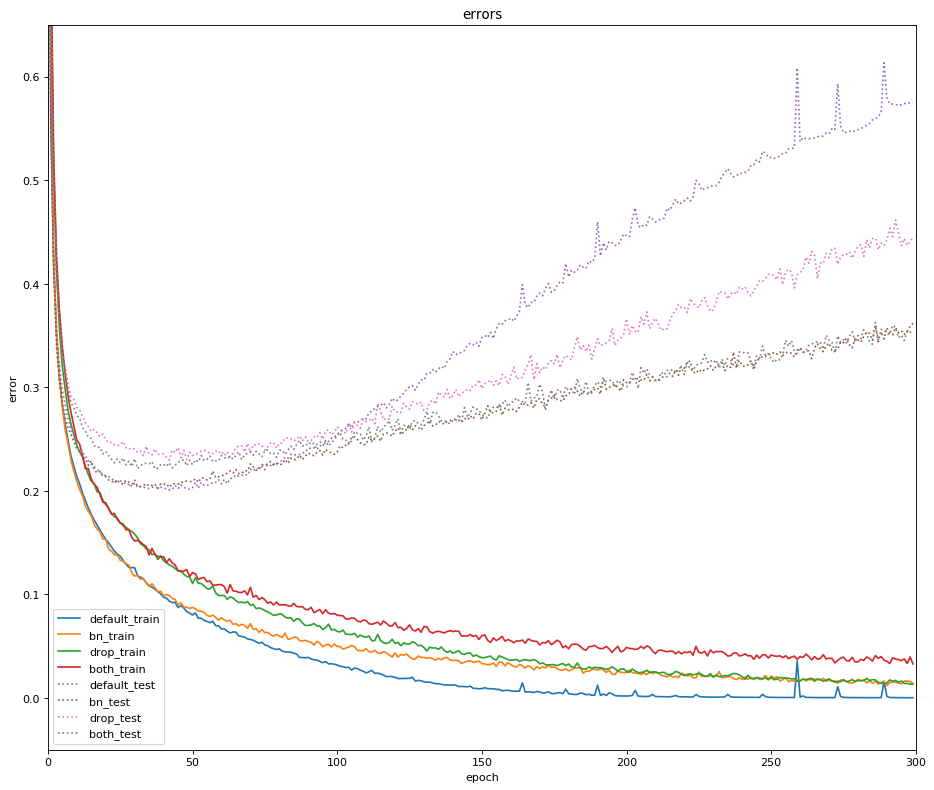

In [11]:
plt.figure(num=None, figsize=(14, 12), dpi=80)
plt.axis([0, 300, -0.05, 0.65])
plot_graphs_double_logs(train_log, test_log, 'loss')

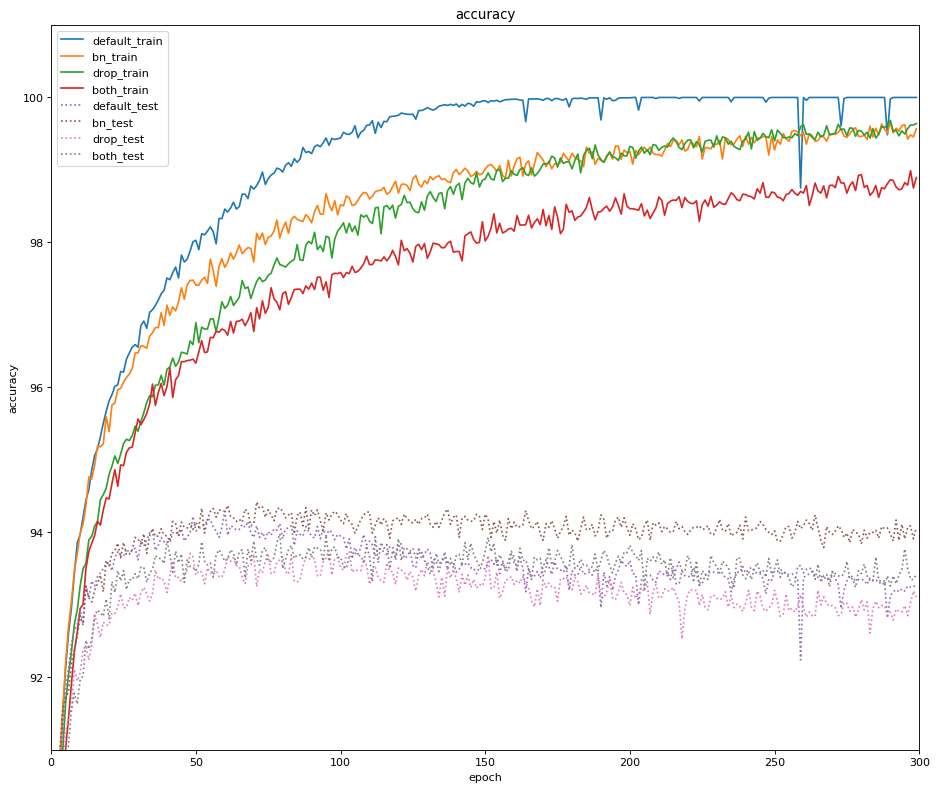

In [12]:
plt.figure(num=None, figsize=(14, 12), dpi=80)
plt.axis([0, 300, 91, 101])
plot_graphs_double_logs(train_log, test_log, 'accuracy')